In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from pathlib import Path

from time import sleep

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.utils import shuffle

from importlib import reload
import sentinel_utils
import keras_model_creator

2024-06-30 16:58:50.248007: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 16:58:50.248391: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 16:58:50.251601: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 16:58:50.278425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 16:58:51.106929: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [14]:
sentinel_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12']
all_bands = sentinel_bands + ['Elevation']
selected_bands = all_bands[:-1]
bands = [all_bands.index(b) for b in selected_bands]
bands

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
reload(sentinel_utils)

shards_dir = Path.home().joinpath('sentinel_data').joinpath('shards')

data_tag = '202003'
sort_key = lambda x: int(x.stem.split('_')[-1])
feature_shards = sorted(list(shards_dir.joinpath(f'features_{data_tag}').glob('feature_*.npy')), key=sort_key)

all_labels = pd.read_csv(Path('data').joinpath('full_dummies.csv'))
sample_shards = 50000
utils = sentinel_utils.SentinelUtils(
    shuffle(feature_shards, random_state=42)[:sample_shards],
    all_labels, min_occurrences=5000, 
    overwrite_existing=False
)

shard_ids = utils.selected_classes.index

In [16]:
architecture = 'simple'
loss = 'binary_crossentropy'
normal_type = 'zscore'
dim = (np.load(feature_shards[0]).shape[:2])

model_dir = Path('models').joinpath(
    f'{architecture}-{loss}-{normal_type}-{len(shard_ids)}-{utils.selected_classes.shape[1]}'
    f'-{len(bands)}-{data_tag}'
)
model_dir.mkdir(parents=True, exist_ok=True)
model_dir

PosixPath('models/simple-binary_crossentropy-zscore-237797-30-10-202003')

In [18]:
reload(keras_model_creator)

params = dict(
    normal_type=normal_type,
    utils=utils,
    dim=dim,
    shards_dir=shards_dir,
    data_tag=data_tag,
    shard_ids=shard_ids,
    model_dir=model_dir,
    bands=bands,
    architecture=architecture,
    loss=loss,
    batch_size=64,
    base_filters=32,
    dropout=0.2,
    epochs=10,
    overwrite=False
)

model, testing_generator = keras_model_creator.KerasModelCreator(**params).run()

Previous training:


epoch,loss,accuracy,recall,precision,auc,prc,microf1score,macrof1score,weightedf1score,val_loss,val_accuracy,val_recall,val_precision,val_auc,val_prc,val_microf1score,val_macrof1score,val_weightedf1score
1,0.1789053082466125,0.2479936480522155,0.2318334430456161,0.6366021633148193,0.879241406917572,0.4337823688983917,0.3398885428905487,0.1269750297069549,0.2759156823158264,0.1655564755201339,0.2990785241127014,0.2794874310493469,0.6283911466598511,0.9057945013046264,0.4956505894660949,0.3868962228298187,0.1615956723690033,0.305176168680191
2,0.1620132625102996,0.295979380607605,0.2877809703350067,0.6766166090965271,0.9079276919364928,0.5090660452842712,0.4038113951683044,0.1691506206989288,0.3324562609195709,0.1596950441598892,0.2936698794364929,0.29099240899086,0.7075278759002686,0.911529779434204,0.5297554135322571,0.4123806655406952,0.161386951804161,0.3213741183280945
3,0.1579477190971374,0.3120433986186981,0.3060217201709747,0.687763512134552,0.9133896827697754,0.529634416103363,0.4235734939575195,0.1857351511716842,0.3520291447639465,0.1531921625137329,0.3191105723381042,0.3334580361843109,0.7091704607009888,0.9199170470237732,0.5600308179855347,0.4536199569702148,0.1831815242767334,0.3609726428985595
4,0.1547583490610122,0.3223956823348999,0.3209769129753113,0.693601131439209,0.9177492260932922,0.5446041226387024,0.4388620555400848,0.1991260945796966,0.367455393075943,0.1482524424791336,0.3337339758872986,0.3271910846233368,0.7353373765945435,0.9273422956466676,0.5818565487861633,0.4528740644454956,0.1955806761980056,0.3686099052429199
5,0.1525520533323288,0.3304430544376373,0.3313168287277221,0.698305606842041,0.9205946326255798,0.5551308393478394,0.4494082033634186,0.209926888346672,0.3788006603717804,0.1498013734817505,0.3311298191547394,0.3170891404151916,0.7315494418144226,0.9258659482002258,0.5714350342750549,0.4424142837524414,0.201507106423378,0.3656263351440429
6,0.1500085890293121,0.3387626409530639,0.3436176478862762,0.7031325697898865,0.9238341450691224,0.567318856716156,0.4616358876228332,0.2210774719715118,0.3911311626434326,0.1584347039461136,0.3197115361690521,0.3552520871162414,0.6747202277183533,0.9117172360420228,0.5520693063735962,0.4654411375522613,0.1968157887458801,0.3703665435314178
7,0.1484100818634033,0.344448059797287,0.3531169891357422,0.7068189978599548,0.9256879687309264,0.5752268433570862,0.4709525108337402,0.2312722355127334,0.4016108810901642,0.1492493897676468,0.3257211446762085,0.3233560919761657,0.73600172996521,0.925807535648346,0.5776549577713013,0.4493110775947571,0.2051413804292678,0.3741233348846435
8,0.1462599635124206,0.3499139547348022,0.3633455336093902,0.7095845937728882,0.9283628463745116,0.5847813487052917,0.4805986285209656,0.2419248223304748,0.4121719598770141,0.1479014754295349,0.3389423191547394,0.3471143841743469,0.7101033329963684,0.9269895553588868,0.5810068845748901,0.4662938416004181,0.2161336988210678,0.3829778730869293
9,0.1445385962724685,0.3555686175823211,0.3724927604198456,0.7122217416763306,0.9304258227348328,0.5927703380584717,0.4891561865806579,0.252921313047409,0.4217967987060547,0.149114653468132,0.3391426205635071,0.3489851355552673,0.718052327632904,0.9249411821365356,0.5785581469535828,0.4696921408176422,0.2181635200977325,0.3898714780807495
epoch,loss,accuracy,recall,precision,auc,prc,microf1score,macrof1score,weightedf1score,val_loss,val_accuracy,val_recall,val_precision,val_auc,val_prc,val_microf1score,val_macrof1score,val_weightedf1score


Building model...
Fitting...


In [19]:
eval_path = model_dir.joinpath('eval.csv')
if eval_path.is_file():
    print(pd.read_csv(eval_path))
else:
    r = model.evaluate(x=testing_generator, verbose=1, return_dict=True)
    df = pd.DataFrame.from_dict(r, orient='index', columns=['score'])
    df.to_csv(eval_path)
    print(df)

78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.3447 - auc: 0.9271 - loss: 0.1470 - macrof1score: 0.2264 - microf1score: 0.4691 - prc: 0.5815 - precision: 0.7191 - recall: 0.3481 - weightedf1score: 0.3999
                    score
accuracy         0.351963
auc              0.927960
loss             0.146271
macrof1score     0.222339
microf1score     0.473694
prc              0.583278
precision        0.719285
recall           0.353124
weightedf1score  0.400899


In [20]:
preds_path = model_dir.joinpath('preds.npy')
if preds_path.is_file():
    y_pred = np.load(preds_path)
else:
    y_pred = model.predict(x=testing_generator, verbose=1)
    np.save(preds_path, y_pred)

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step


In [21]:
labels_path = model_dir.joinpath('true.npy')
total_batches = testing_generator.__len__()
if labels_path.is_file():
    y_true = np.load(labels_path)
else:
    y_true = []
    for i, (x, y) in enumerate(tqdm(testing_generator, total=total_batches-1)):
        y_true.append(y)
        if i > total_batches - 2:
            break
    y_true = np.vstack(y_true)
    np.save(labels_path, y_true)

  0%|          | 0/77 [00:00<?, ?it/s]

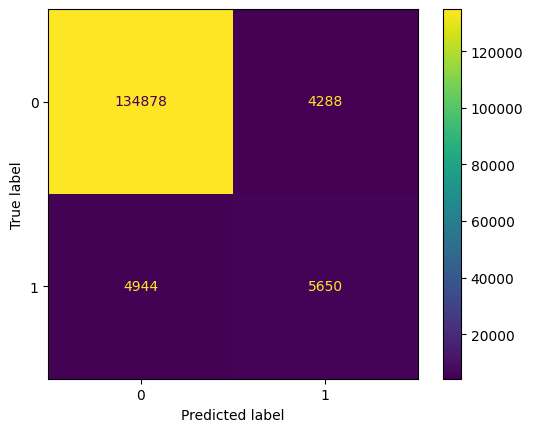

In [22]:
cm = confusion_matrix(y_true.flatten().astype(int), (y_pred > 0.3).flatten().astype(int))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

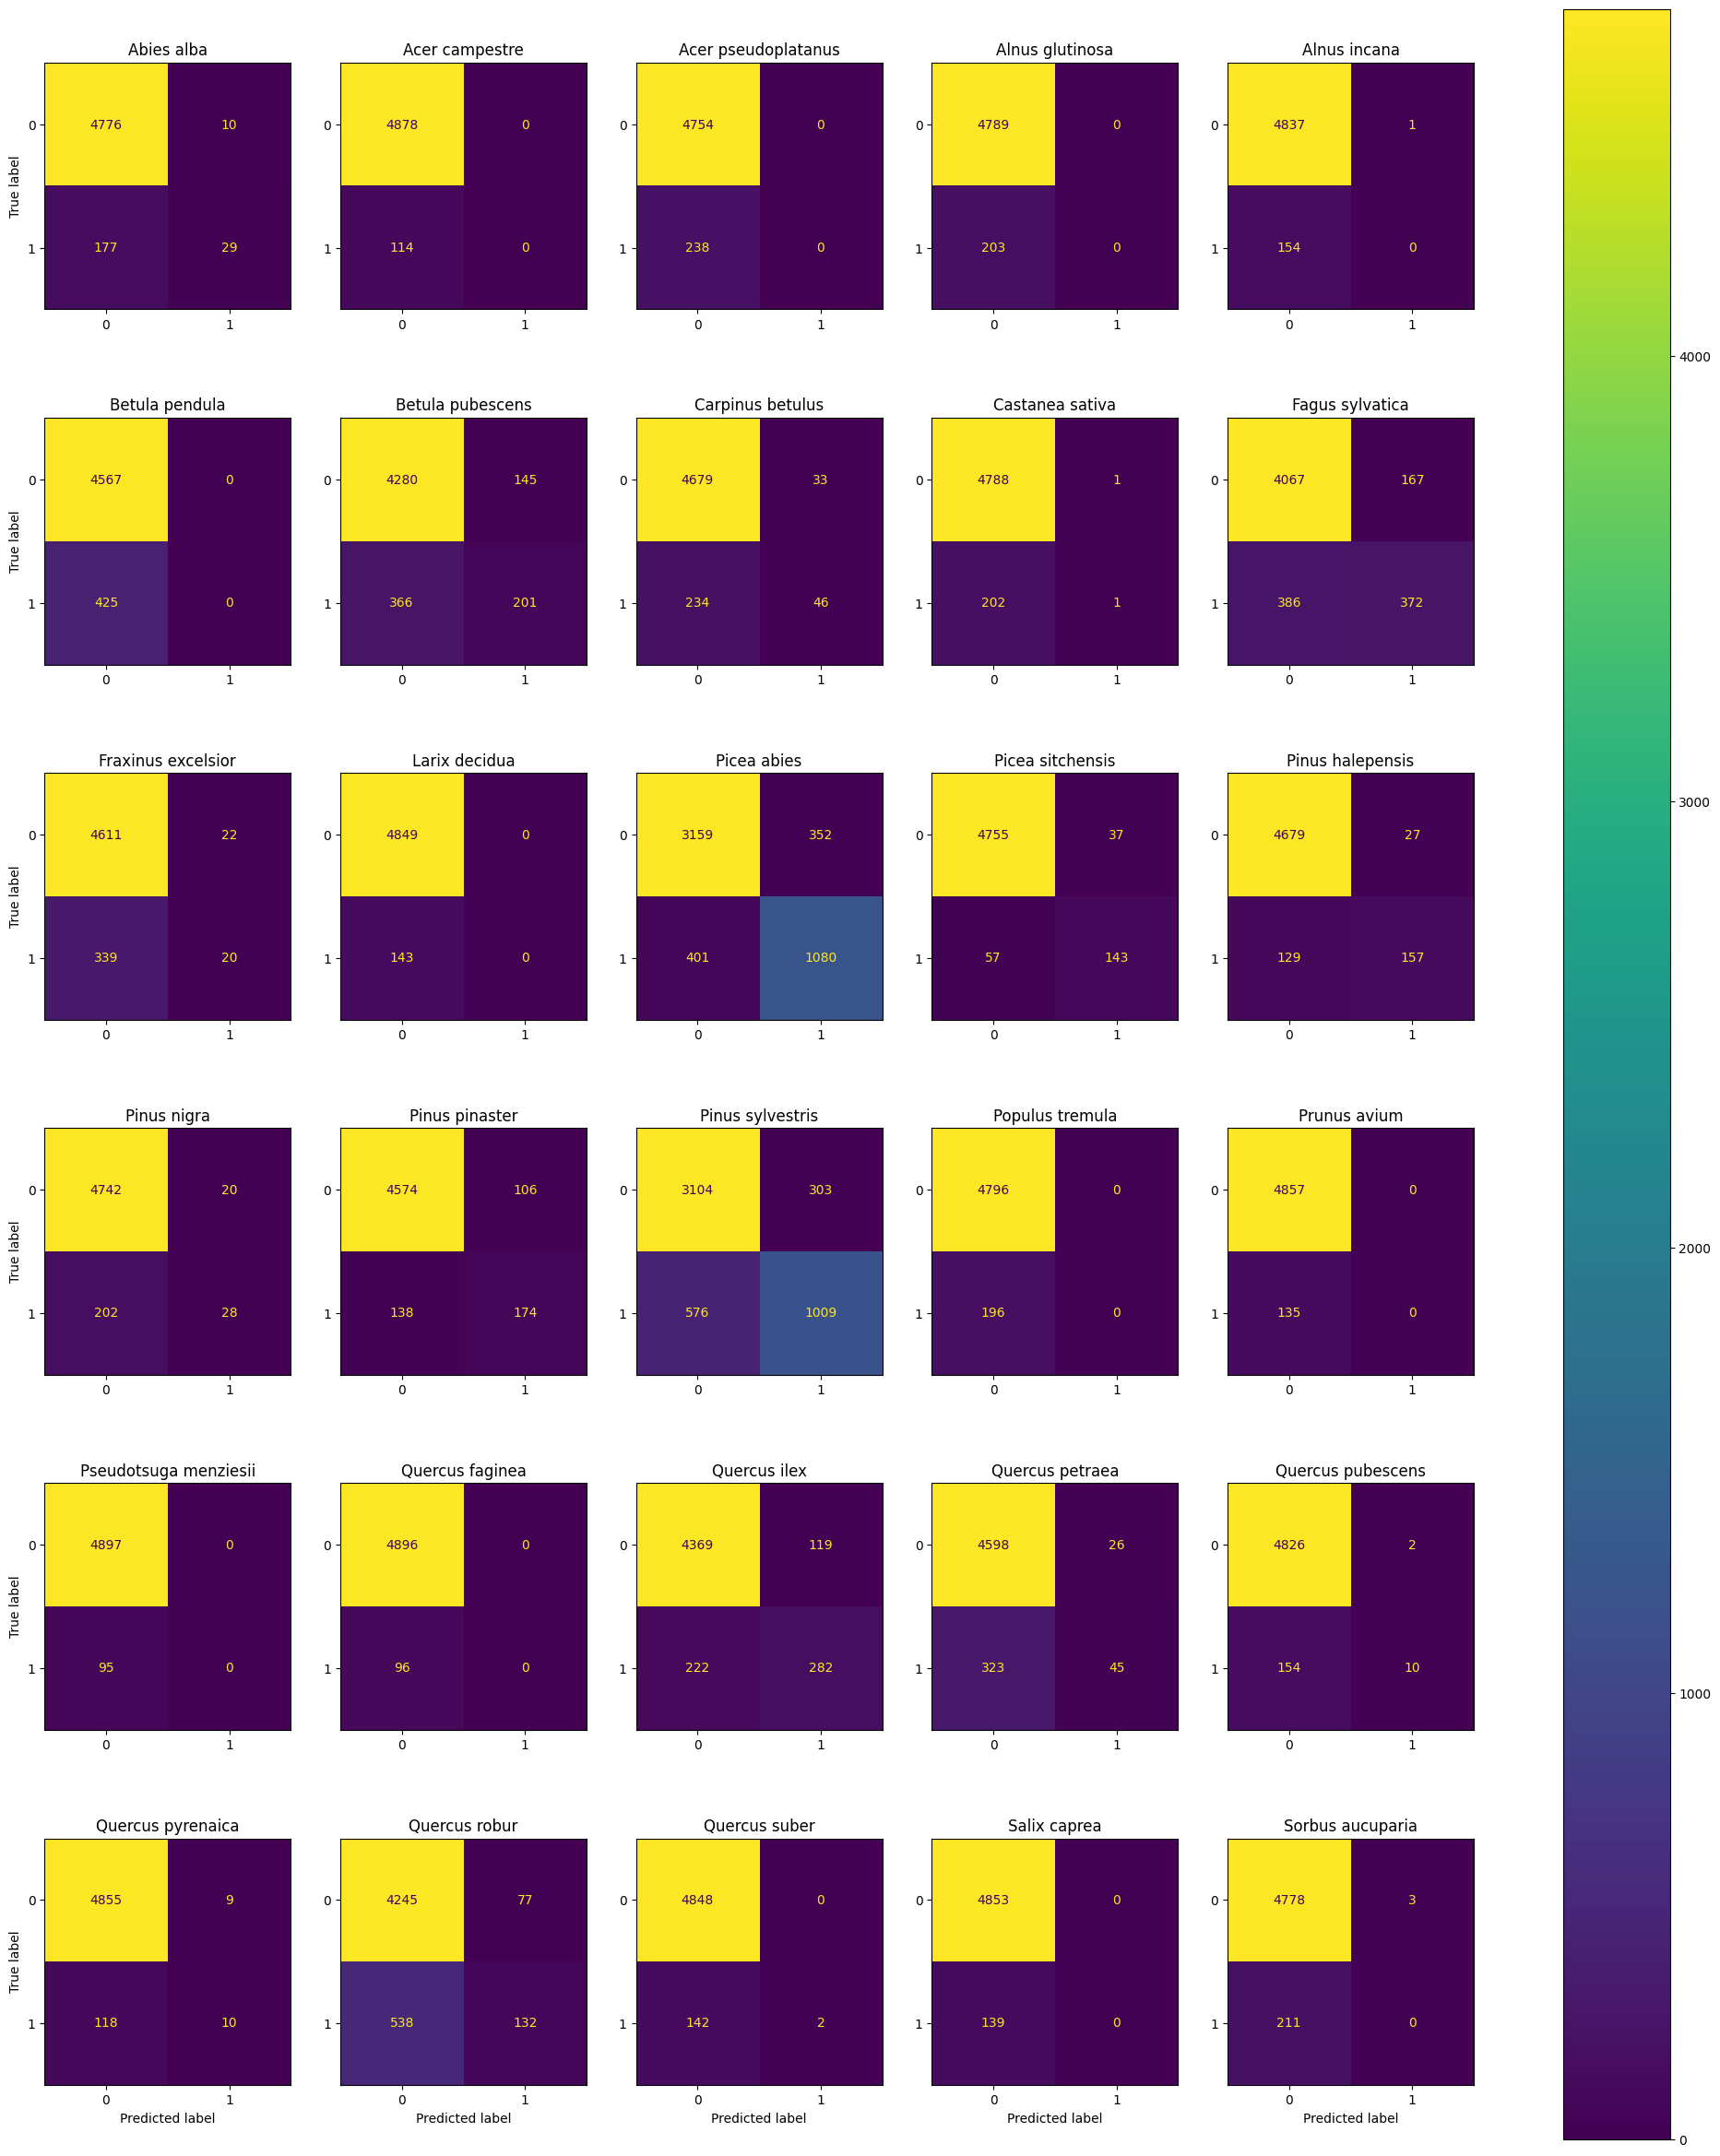

In [23]:
import matplotlib.pyplot as plt

class_names = utils.selected_classes.columns

f, axes = plt.subplots(6, 5, figsize=(25, 30))
axes = axes.ravel()
for label in range(y_true.shape[1]):
    cm = confusion_matrix(y_true[..., label].astype(int), (y_pred[..., label] > 0.5).astype(int))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=axes[label], values_format='.4g')
    disp.ax_.set_title(f'{class_names[label]}')
    if label < 25:
        disp.ax_.set_xlabel('')
    if label % 5 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.2, hspace=0.001)
f.colorbar(disp.im_, ax=axes)
plt.show()


In [11]:
# tf.keras.utils.plot_model(model, show_shapes=True)
# model.summary()

In [12]:
# import subprocess
# subprocess.run(['sudo', 'shutdown', 'now'])